**<font size=6>神经网络与深度学习-HW1</font>**

**<font size=4>构建两层神经网络分类器</font>**

github repo链接：

本项目大致步骤如下：

1. 导入MNIST数据集，将图像矩阵和标签分别存储到两个数组中；

2. 首先定义一个神经网络类，该类包含了网络的构造函数以及前馈和反馈的函数，构造函数应该设置网络的层数和大小，并在内部创建权重和偏置变量；

3. 选择一个合适的激活函数，初始化权重和偏置值；

4. 定义前馈和反馈的函数，在前馈函数中计算网络的输出，反向传播得到梯度并更新权重和偏置；

5. 选择合适损失函数作为网络的优化目标，计算loss，同时，考虑加入L2正则化；

6. 选择SGD优化器，在该函数中根据损失函数梯度给出相应的参数更新规则，例如学习率、动量等；

7. 在训练过程中，每次更新时记录和输出loss和准确率；

8. 对隐藏层大小、学习率和正则化强度进行参数查找，用多轮交叉验证确定合适的参数值；

9. 最后，使用保存的模型对测试集进行预测并计算分类精度。

In [ ]:
import os 
os.chdir('/Users/lengchenxi/Documents/1_学习/1-0_FDU/2022-2023第二学期/4_神经网络和深度学习/0324_HW1')

# 数据导入和预处理

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNIST数据导入
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 数据初步处理
X_train = X_train / 255.
X_test = X_test / 255.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = np.eye(10)[y_train.astype(int)]
y_test = np.eye(10)[y_test.astype(int)]

# 初始化网络参数

In [1]:
# 定义每层基本属性
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 10

# 初始化参数
W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))

2023-04-05 11:38:30.688009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 [==============================] - 12s 1us/step


# 定义激活函数、损失函数、前向传播、反向传播算法

In [5]:
# 激活函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# 基于L2正则化定义交叉熵损失函数
def cross_entropy_loss(y_pred, y_true, reg_lambda):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / m
    loss += reg_lambda / (2 * m) * (np.sum(W1**2) + np.sum(W2**2))
    return loss

# 前向传播
def forward(X):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)

    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)

    return a2

# 反向传播
def backward(X, y_true, y_pred, a1, reg_lambda):
    m = y_true.shape[0]
    
    dL_dz2 = (y_pred - y_true) / m
    dL_dW2 = np.dot(a1.T, dL_dz2)
    dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
 
    dL_da1 = np.dot(dL_dz2, W2.T)
    dL_dz1 = dL_da1 * (a1 > 0)
    dL_dW1 = np.dot(X.T, dL_dz1) + reg_lambda / m * W1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
    
    return dL_dW1, dL_db1, dL_dW2, dL_db2

# 定义超参数并开始训练和测试

In [6]:
# 定义超参数
learning_rate = 0.01
num_epochs = 1000
batch_size = 128
reg_lambda = 0.01

# 定义存储损失和精度数据的数组
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# 训练&测试
for epoch in range(num_epochs):
    # Shuffle the training data
    indices = np.random.permutation(X_train.shape[0])
    X_train = X_train[indices]
    y_train = y_train[indices]

    # 训练模型
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # 前向传播
        y_pred = forward(X_batch)

        # 计算训练集损失和精度
        train_loss = cross_entropy_loss(y_pred, y_batch, reg_lambda)
        train_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))

        # 反向传播计算梯度
        dL_dW1, dL_db1, dL_dW2, dL_db2 = backward(X_batch, y_batch, y_pred, relu(np.dot(X_batch, W1) + b1), reg_lambda)

        # 梯度下降更新权重和偏置
        W1 -= learning_rate * dL_dW1
        b1 -= learning_rate * dL_db1
        W2 -= learning_rate * dL_dW2
        b2 -= learning_rate * dL_db2

    # 测试集测试
    y_test_pred = forward(X_test)

    # 计算测试集损失和精度
    test_loss = cross_entropy_loss(y_test_pred, y_test, reg_lambda)
    test_acc = np.mean(np.argmax(y_test_pred, axis=1) == np.argmax(y_test, axis=1))

    # 输出当前训练和测试的损失和精度
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # 存储损失和精度数据
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# 存储模型
np.savez("mnist_model.npz", W1=W1, b1=b1, W2=W2, b2=b2)

Epoch 1/1000 - Train Loss: 10.6708, Train Acc: 0.5729, Test Loss: 5.6011, Test Acc: 0.6616
Epoch 2/1000 - Train Loss: 5.4698, Train Acc: 0.7292, Test Loss: 3.4975, Test Acc: 0.7439
Epoch 3/1000 - Train Loss: 5.1355, Train Acc: 0.8021, Test Loss: 2.7134, Test Acc: 0.7721
Epoch 4/1000 - Train Loss: 5.9094, Train Acc: 0.7396, Test Loss: 2.2244, Test Acc: 0.7876
Epoch 5/1000 - Train Loss: 4.2397, Train Acc: 0.7917, Test Loss: 1.9162, Test Acc: 0.7965
Epoch 6/1000 - Train Loss: 4.1184, Train Acc: 0.8229, Test Loss: 1.6772, Test Acc: 0.8078
Epoch 7/1000 - Train Loss: 4.6811, Train Acc: 0.7708, Test Loss: 1.5011, Test Acc: 0.8127
Epoch 8/1000 - Train Loss: 3.6917, Train Acc: 0.8229, Test Loss: 1.3642, Test Acc: 0.8150
Epoch 9/1000 - Train Loss: 3.8931, Train Acc: 0.8125, Test Loss: 1.2442, Test Acc: 0.8203
Epoch 10/1000 - Train Loss: 3.8888, Train Acc: 0.8021, Test Loss: 1.1442, Test Acc: 0.8218
Epoch 11/1000 - Train Loss: 3.2880, Train Acc: 0.8125, Test Loss: 1.0669, Test Acc: 0.8249
Epoch 1

Epoch 92/1000 - Train Loss: 2.9110, Train Acc: 0.8750, Test Loss: 0.3924, Test Acc: 0.8916
Epoch 93/1000 - Train Loss: 2.6769, Train Acc: 0.8958, Test Loss: 0.3942, Test Acc: 0.8922
Epoch 94/1000 - Train Loss: 2.7556, Train Acc: 0.8646, Test Loss: 0.3930, Test Acc: 0.8893
Epoch 95/1000 - Train Loss: 2.5660, Train Acc: 0.9583, Test Loss: 0.3918, Test Acc: 0.8927
Epoch 96/1000 - Train Loss: 2.8111, Train Acc: 0.8542, Test Loss: 0.3902, Test Acc: 0.8917
Epoch 97/1000 - Train Loss: 2.7609, Train Acc: 0.8854, Test Loss: 0.3931, Test Acc: 0.8913
Epoch 98/1000 - Train Loss: 2.6485, Train Acc: 0.9375, Test Loss: 0.3895, Test Acc: 0.8921
Epoch 99/1000 - Train Loss: 2.6534, Train Acc: 0.9167, Test Loss: 0.3848, Test Acc: 0.8937
Epoch 100/1000 - Train Loss: 2.8503, Train Acc: 0.8542, Test Loss: 0.3878, Test Acc: 0.8950
Epoch 101/1000 - Train Loss: 2.7427, Train Acc: 0.9167, Test Loss: 0.3894, Test Acc: 0.8955
Epoch 102/1000 - Train Loss: 2.7062, Train Acc: 0.8958, Test Loss: 0.4034, Test Acc: 0.8

Epoch 182/1000 - Train Loss: 2.4968, Train Acc: 0.9271, Test Loss: 0.3249, Test Acc: 0.9109
Epoch 183/1000 - Train Loss: 2.4903, Train Acc: 0.9479, Test Loss: 0.3270, Test Acc: 0.9111
Epoch 184/1000 - Train Loss: 2.4387, Train Acc: 0.9479, Test Loss: 0.3223, Test Acc: 0.9126
Epoch 185/1000 - Train Loss: 2.4412, Train Acc: 0.9479, Test Loss: 0.3226, Test Acc: 0.9139
Epoch 186/1000 - Train Loss: 2.5572, Train Acc: 0.9062, Test Loss: 0.3306, Test Acc: 0.9090
Epoch 187/1000 - Train Loss: 2.5758, Train Acc: 0.8958, Test Loss: 0.3197, Test Acc: 0.9128
Epoch 188/1000 - Train Loss: 2.6625, Train Acc: 0.8854, Test Loss: 0.3210, Test Acc: 0.9117
Epoch 189/1000 - Train Loss: 2.4743, Train Acc: 0.9375, Test Loss: 0.3189, Test Acc: 0.9131
Epoch 190/1000 - Train Loss: 2.4841, Train Acc: 0.9479, Test Loss: 0.3177, Test Acc: 0.9137
Epoch 191/1000 - Train Loss: 2.4819, Train Acc: 0.9271, Test Loss: 0.3192, Test Acc: 0.9132
Epoch 192/1000 - Train Loss: 2.3658, Train Acc: 0.9688, Test Loss: 0.3190, Test 

Epoch 272/1000 - Train Loss: 2.3583, Train Acc: 0.8958, Test Loss: 0.2903, Test Acc: 0.9213
Epoch 273/1000 - Train Loss: 2.3310, Train Acc: 0.9271, Test Loss: 0.2938, Test Acc: 0.9197
Epoch 274/1000 - Train Loss: 2.5332, Train Acc: 0.8958, Test Loss: 0.2858, Test Acc: 0.9221
Epoch 275/1000 - Train Loss: 2.3153, Train Acc: 0.9062, Test Loss: 0.2890, Test Acc: 0.9218
Epoch 276/1000 - Train Loss: 2.4683, Train Acc: 0.9062, Test Loss: 0.2852, Test Acc: 0.9213
Epoch 277/1000 - Train Loss: 2.3598, Train Acc: 0.9271, Test Loss: 0.2853, Test Acc: 0.9228
Epoch 278/1000 - Train Loss: 2.2673, Train Acc: 0.9583, Test Loss: 0.2869, Test Acc: 0.9214
Epoch 279/1000 - Train Loss: 2.3370, Train Acc: 0.9375, Test Loss: 0.2844, Test Acc: 0.9229
Epoch 280/1000 - Train Loss: 2.5513, Train Acc: 0.8958, Test Loss: 0.2836, Test Acc: 0.9216
Epoch 281/1000 - Train Loss: 2.2761, Train Acc: 0.9479, Test Loss: 0.2817, Test Acc: 0.9224
Epoch 282/1000 - Train Loss: 2.2315, Train Acc: 0.9479, Test Loss: 0.2829, Test 

Epoch 362/1000 - Train Loss: 2.1101, Train Acc: 0.9688, Test Loss: 0.2707, Test Acc: 0.9269
Epoch 363/1000 - Train Loss: 2.1372, Train Acc: 0.9688, Test Loss: 0.2622, Test Acc: 0.9292
Epoch 364/1000 - Train Loss: 2.1441, Train Acc: 0.9375, Test Loss: 0.2625, Test Acc: 0.9284
Epoch 365/1000 - Train Loss: 2.2968, Train Acc: 0.8854, Test Loss: 0.2609, Test Acc: 0.9296
Epoch 366/1000 - Train Loss: 2.0962, Train Acc: 0.9583, Test Loss: 0.2601, Test Acc: 0.9285
Epoch 367/1000 - Train Loss: 2.2301, Train Acc: 0.9062, Test Loss: 0.2615, Test Acc: 0.9302
Epoch 368/1000 - Train Loss: 2.1952, Train Acc: 0.9167, Test Loss: 0.2650, Test Acc: 0.9272
Epoch 369/1000 - Train Loss: 2.1958, Train Acc: 0.9271, Test Loss: 0.2610, Test Acc: 0.9298
Epoch 370/1000 - Train Loss: 2.0797, Train Acc: 0.9688, Test Loss: 0.2588, Test Acc: 0.9295
Epoch 371/1000 - Train Loss: 2.3234, Train Acc: 0.9062, Test Loss: 0.2613, Test Acc: 0.9298
Epoch 372/1000 - Train Loss: 2.1170, Train Acc: 0.9375, Test Loss: 0.2600, Test 

Epoch 452/1000 - Train Loss: 2.0511, Train Acc: 0.9479, Test Loss: 0.2432, Test Acc: 0.9332
Epoch 453/1000 - Train Loss: 1.9435, Train Acc: 0.9792, Test Loss: 0.2429, Test Acc: 0.9342
Epoch 454/1000 - Train Loss: 2.0414, Train Acc: 0.9375, Test Loss: 0.2462, Test Acc: 0.9358
Epoch 455/1000 - Train Loss: 1.9485, Train Acc: 0.9479, Test Loss: 0.2405, Test Acc: 0.9345
Epoch 456/1000 - Train Loss: 2.0151, Train Acc: 0.9583, Test Loss: 0.2409, Test Acc: 0.9344
Epoch 457/1000 - Train Loss: 2.0019, Train Acc: 0.9375, Test Loss: 0.2426, Test Acc: 0.9333
Epoch 458/1000 - Train Loss: 1.9721, Train Acc: 0.9583, Test Loss: 0.2392, Test Acc: 0.9337
Epoch 459/1000 - Train Loss: 1.9850, Train Acc: 0.9688, Test Loss: 0.2416, Test Acc: 0.9345
Epoch 460/1000 - Train Loss: 2.0796, Train Acc: 0.9375, Test Loss: 0.2415, Test Acc: 0.9349
Epoch 461/1000 - Train Loss: 1.9786, Train Acc: 0.9583, Test Loss: 0.2391, Test Acc: 0.9343
Epoch 462/1000 - Train Loss: 2.0228, Train Acc: 0.9375, Test Loss: 0.2395, Test 

Epoch 542/1000 - Train Loss: 1.8163, Train Acc: 0.9688, Test Loss: 0.2265, Test Acc: 0.9387
Epoch 543/1000 - Train Loss: 1.9553, Train Acc: 0.9062, Test Loss: 0.2257, Test Acc: 0.9396
Epoch 544/1000 - Train Loss: 1.8612, Train Acc: 0.9375, Test Loss: 0.2262, Test Acc: 0.9391
Epoch 545/1000 - Train Loss: 1.8552, Train Acc: 0.9688, Test Loss: 0.2267, Test Acc: 0.9389
Epoch 546/1000 - Train Loss: 1.8648, Train Acc: 0.9479, Test Loss: 0.2248, Test Acc: 0.9389
Epoch 547/1000 - Train Loss: 1.8945, Train Acc: 0.9271, Test Loss: 0.2258, Test Acc: 0.9391
Epoch 548/1000 - Train Loss: 1.8596, Train Acc: 0.9688, Test Loss: 0.2243, Test Acc: 0.9392
Epoch 549/1000 - Train Loss: 2.0355, Train Acc: 0.9062, Test Loss: 0.2295, Test Acc: 0.9385
Epoch 550/1000 - Train Loss: 1.8298, Train Acc: 0.9583, Test Loss: 0.2282, Test Acc: 0.9375
Epoch 551/1000 - Train Loss: 1.8721, Train Acc: 0.9479, Test Loss: 0.2254, Test Acc: 0.9385
Epoch 552/1000 - Train Loss: 1.8380, Train Acc: 0.9583, Test Loss: 0.2231, Test 

Epoch 632/1000 - Train Loss: 1.9895, Train Acc: 0.8958, Test Loss: 0.2145, Test Acc: 0.9425
Epoch 633/1000 - Train Loss: 1.7302, Train Acc: 0.9896, Test Loss: 0.2133, Test Acc: 0.9427
Epoch 634/1000 - Train Loss: 1.7431, Train Acc: 0.9688, Test Loss: 0.2148, Test Acc: 0.9438
Epoch 635/1000 - Train Loss: 1.8656, Train Acc: 0.9688, Test Loss: 0.2137, Test Acc: 0.9425
Epoch 636/1000 - Train Loss: 1.8178, Train Acc: 0.9271, Test Loss: 0.2121, Test Acc: 0.9433
Epoch 637/1000 - Train Loss: 1.7054, Train Acc: 0.9896, Test Loss: 0.2124, Test Acc: 0.9427
Epoch 638/1000 - Train Loss: 1.8511, Train Acc: 0.9167, Test Loss: 0.2123, Test Acc: 0.9438
Epoch 639/1000 - Train Loss: 1.6780, Train Acc: 0.9896, Test Loss: 0.2119, Test Acc: 0.9435
Epoch 640/1000 - Train Loss: 1.6936, Train Acc: 0.9792, Test Loss: 0.2131, Test Acc: 0.9432
Epoch 641/1000 - Train Loss: 1.8251, Train Acc: 0.9479, Test Loss: 0.2107, Test Acc: 0.9436
Epoch 642/1000 - Train Loss: 1.6757, Train Acc: 0.9896, Test Loss: 0.2109, Test 

Epoch 722/1000 - Train Loss: 1.6320, Train Acc: 0.9479, Test Loss: 0.2005, Test Acc: 0.9464
Epoch 723/1000 - Train Loss: 1.6338, Train Acc: 0.9583, Test Loss: 0.2030, Test Acc: 0.9460
Epoch 724/1000 - Train Loss: 1.6130, Train Acc: 0.9792, Test Loss: 0.2020, Test Acc: 0.9466
Epoch 725/1000 - Train Loss: 1.7213, Train Acc: 0.9479, Test Loss: 0.2024, Test Acc: 0.9466
Epoch 726/1000 - Train Loss: 1.7054, Train Acc: 0.9375, Test Loss: 0.2004, Test Acc: 0.9468
Epoch 727/1000 - Train Loss: 1.6824, Train Acc: 0.9688, Test Loss: 0.2031, Test Acc: 0.9458
Epoch 728/1000 - Train Loss: 1.6832, Train Acc: 0.9583, Test Loss: 0.2009, Test Acc: 0.9462
Epoch 729/1000 - Train Loss: 1.6309, Train Acc: 0.9583, Test Loss: 0.2018, Test Acc: 0.9459
Epoch 730/1000 - Train Loss: 1.6815, Train Acc: 0.9583, Test Loss: 0.1994, Test Acc: 0.9466
Epoch 731/1000 - Train Loss: 1.6259, Train Acc: 0.9688, Test Loss: 0.1999, Test Acc: 0.9477
Epoch 732/1000 - Train Loss: 1.6210, Train Acc: 0.9375, Test Loss: 0.2012, Test 

Epoch 812/1000 - Train Loss: 1.5502, Train Acc: 0.9583, Test Loss: 0.1920, Test Acc: 0.9498
Epoch 813/1000 - Train Loss: 1.5828, Train Acc: 0.9375, Test Loss: 0.1917, Test Acc: 0.9487
Epoch 814/1000 - Train Loss: 1.5436, Train Acc: 0.9792, Test Loss: 0.1939, Test Acc: 0.9483
Epoch 815/1000 - Train Loss: 1.5315, Train Acc: 0.9688, Test Loss: 0.1920, Test Acc: 0.9495
Epoch 816/1000 - Train Loss: 1.4799, Train Acc: 0.9896, Test Loss: 0.1918, Test Acc: 0.9493
Epoch 817/1000 - Train Loss: 1.5915, Train Acc: 0.9479, Test Loss: 0.1925, Test Acc: 0.9488
Epoch 818/1000 - Train Loss: 1.5142, Train Acc: 0.9688, Test Loss: 0.1912, Test Acc: 0.9489
Epoch 819/1000 - Train Loss: 1.4707, Train Acc: 1.0000, Test Loss: 0.1913, Test Acc: 0.9481
Epoch 820/1000 - Train Loss: 1.4989, Train Acc: 0.9583, Test Loss: 0.1911, Test Acc: 0.9490
Epoch 821/1000 - Train Loss: 1.6078, Train Acc: 0.9375, Test Loss: 0.1934, Test Acc: 0.9477
Epoch 822/1000 - Train Loss: 1.5273, Train Acc: 0.9583, Test Loss: 0.1913, Test 

Epoch 902/1000 - Train Loss: 1.4766, Train Acc: 0.9792, Test Loss: 0.1844, Test Acc: 0.9503
Epoch 903/1000 - Train Loss: 1.5528, Train Acc: 0.9479, Test Loss: 0.1849, Test Acc: 0.9513
Epoch 904/1000 - Train Loss: 1.4248, Train Acc: 0.9792, Test Loss: 0.1834, Test Acc: 0.9515
Epoch 905/1000 - Train Loss: 1.4248, Train Acc: 0.9479, Test Loss: 0.1852, Test Acc: 0.9508
Epoch 906/1000 - Train Loss: 1.4109, Train Acc: 0.9792, Test Loss: 0.1838, Test Acc: 0.9507
Epoch 907/1000 - Train Loss: 1.4774, Train Acc: 0.9479, Test Loss: 0.1850, Test Acc: 0.9509
Epoch 908/1000 - Train Loss: 1.4757, Train Acc: 0.9375, Test Loss: 0.1838, Test Acc: 0.9517
Epoch 909/1000 - Train Loss: 1.5134, Train Acc: 0.9375, Test Loss: 0.1836, Test Acc: 0.9506
Epoch 910/1000 - Train Loss: 1.4508, Train Acc: 0.9792, Test Loss: 0.1836, Test Acc: 0.9511
Epoch 911/1000 - Train Loss: 1.3916, Train Acc: 0.9688, Test Loss: 0.1837, Test Acc: 0.9520
Epoch 912/1000 - Train Loss: 1.4516, Train Acc: 0.9375, Test Loss: 0.1841, Test 

Epoch 992/1000 - Train Loss: 1.4298, Train Acc: 0.9688, Test Loss: 0.1783, Test Acc: 0.9523
Epoch 993/1000 - Train Loss: 1.3324, Train Acc: 0.9688, Test Loss: 0.1773, Test Acc: 0.9531
Epoch 994/1000 - Train Loss: 1.2993, Train Acc: 0.9896, Test Loss: 0.1778, Test Acc: 0.9532
Epoch 995/1000 - Train Loss: 1.3936, Train Acc: 0.9479, Test Loss: 0.1778, Test Acc: 0.9523
Epoch 996/1000 - Train Loss: 1.2872, Train Acc: 0.9896, Test Loss: 0.1777, Test Acc: 0.9523
Epoch 997/1000 - Train Loss: 1.4233, Train Acc: 0.9479, Test Loss: 0.1776, Test Acc: 0.9532
Epoch 998/1000 - Train Loss: 1.3590, Train Acc: 0.9688, Test Loss: 0.1779, Test Acc: 0.9529
Epoch 999/1000 - Train Loss: 1.4103, Train Acc: 0.9375, Test Loss: 0.1780, Test Acc: 0.9524
Epoch 1000/1000 - Train Loss: 1.3316, Train Acc: 0.9896, Test Loss: 0.1771, Test Acc: 0.9525


# 可视化模型表现

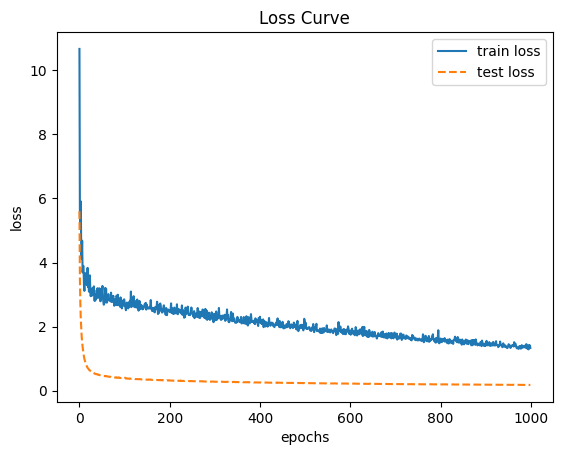

In [13]:
# 训练和测试的loss曲线
x = np.arange(len(train_losses))
plt.title("Loss Curve")
plt.plot(x, train_losses, label='train loss')
plt.plot(x, test_losses, label='test loss', linestyle='--')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss_image.jpg')
plt.show()

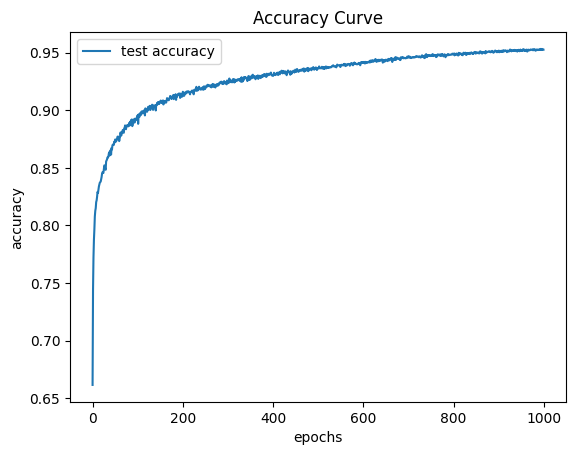

In [14]:
# 测试的accuracy曲线
plt.title("Accuracy Curve")
plt.plot(x, test_accs, label='test accuracy')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig('accuracy_image.jpg')
plt.show()